# Modeling Wine Quality: Analyzing Variable Influences

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from statsmodels.miscmodels.ordinal_model import OrderedModel
from scipy.stats import spearmanr, bootstrap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    r2_score,
)
from sklearn.base import clone
from sklearn.utils import resample
from mord import LogisticAT
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from utils.functions import *

# Dataset Cleaning

The main objectives for this part of the notebook are:

- Get familiar with the dataset.
- Discover data quality issues.
- Address the data quality issues.

My goal is to identify common issues in the data and build a pipeline to address them in a single function.

## Data Profiling

The dataset used for this analysis is a single CSV file.

### Contents

In [2]:
wines_raw = pd.read_csv("winequality-red.csv")
rows, columns = wines_raw.shape
print(f"{rows} rows and {columns} columns.")
wines_raw.head()

1599 rows and 12 columns.


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Observations:
- The table consists of 11 predictors (independent variables) and a target (dependent variable) "quality".
- There are 1599 wine samples.

### Missing Values

In [3]:
wines_raw.isnull().any().any()

False

Observations:
- No missing values.

### Duplicates

The wines are not identified by any ID number, and we only have their biochemical parameters. I'll check for duplicates by inspecting entire rows.

In [4]:
len(wines_raw[wines_raw.duplicated()])

240

Observations:
- There are 240 wines that have the same characteristics as another wine in dataset. This leaves 1,359 wines with different characteristics.
- Even though duplicates represent unique wines, or at least there is no reason to think these are errors, this information would cause the model to overemphasize certain values, potentially distorting the regression coefficients.
  
Impact:
- I will keep the first occurrence and drop all subsequent duplicates.

### Outliers

Some of the features are skewed, have tails or outliers. For conciseness, I will illustrate this with a single example.

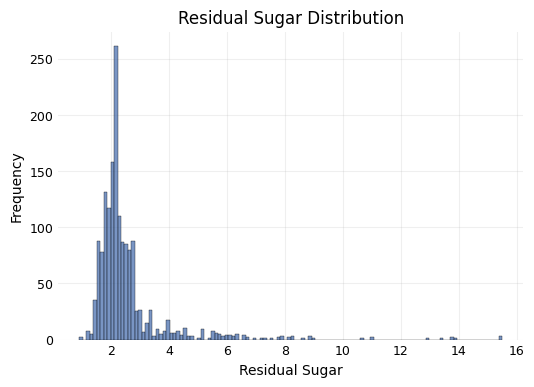

In [5]:
sns.set_palette("deep")
histogram(wines_raw, "residual sugar")

Observations:
- This predictor has outliers.
- There is no reason to believe that these points are errors or distorted in any way. These points could significantly influence a linear model.
 
Impact:
- I will transform predictors into logarithmic form.
- Even though not every feature is skewed or has outliers, for simplicity, I will apply this change to all of them, as there is no drawback.

### Feature Scales

In [6]:
wines_raw.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Observations:
- Features are on different scales. For example, "citric acid" ranges from 0 to 1, while "total sulfur dioxide" ranges from 6 to 289.

Impact:
- To ensure that all features contribute equally to the model, I will apply normalization to bring them to a comparable scale.

## Data Preprocessing Pipeline

Based on the analysis above, the following data cleaning and pre-processing steps will be taken:
- Duplicate rows will be removed to ensure each observation is unique.
- To reduce the effect of skewness and outliers, all features will be log-transformed.
- Features will be normalized to ensure they are on a comparable scale and contribute appropriately.

For the modeling phase, preprocessing steps like standard scaling must be calculated and implemented separately on the training and testing datasets to avoid data leakage. The duplicate removal has to be applied to the whole dataset outside of the function.

In [7]:
def cleaning_pipeline(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Data cleaning and processing pipeline.

    Args:
        dataframe (pd.DataFrame): The input DataFrame containing the data to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with log-transformed, and normalized predictor features.
    """
    dataframe_clean = dataframe.copy()
    if "quality" in dataframe_clean.columns:
        all_predictors = dataframe_clean.drop(columns=["quality"]).columns.tolist()
    else:
        all_predictors = dataframe_clean.columns.tolist()
    for col in all_predictors:
        dataframe_clean[col] = np.log1p(dataframe_clean[col])
    scaler = StandardScaler()
    dataframe_clean[all_predictors] = scaler.fit_transform(
        dataframe_clean[all_predictors]
    )
    return dataframe_clean

wines_no_duplicates = wines_raw.drop_duplicates()
wines = cleaning_pipeline(wines_no_duplicates.copy())

In [6]:
# def cleaning_pipeline(dataframe: pd.DataFrame) -> pd.DataFrame:
#     """
#     Data cleaning and processing pipeline.

#     Args:
#         dataframe (pd.DataFrame): The input DataFrame containing the data to be cleaned.

#     Returns:
#         pd.DataFrame: The cleaned DataFrame with log-transformed, and normalized predictor features.
#     """
#     dataframe_clean = dataframe.copy()
#     if "quality" in dataframe_clean.columns:
#         all_predictors = dataframe_clean.drop(columns=["quality"]).columns.tolist()
#     else:
#         all_predictors = dataframe_clean.columns.tolist()
#     scaler = StandardScaler()
#     dataframe_clean[all_predictors] = scaler.fit_transform(
#         dataframe_clean[all_predictors]
#     )
#     return dataframe_clean

# wines_raw = pd.read_csv("winequality-red.csv")
# wines_no_duplicates = wines_raw.drop_duplicates()

# X_raw = wines_no_duplicates.drop(columns=["quality"])
# y_raw = wines_no_duplicates["quality"]
# X_train_unclean, X_test_unclean, y_train, y_test = train_test_split(
#     X_raw, y_raw, test_size=0.2, random_state=32
# )
# X_train = cleaning_pipeline(X_train_unclean)
# X_train = sm.add_constant(X_train)
# model = sm.OLS(y_train, X_train).fit()
# print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     57.50
Date:                Sat, 15 Jun 2024   Prob (F-statistic):          4.35e-100
Time:                        10:49:03   Log-Likelihood:                -1059.9
No. Observations:                1087   AIC:                             2144.
Df Residuals:                    1075   BIC:                             2204.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.6329 

# EDA

The main objectives for this part of notebook are:

- Explore the cleaned dataset by performing univariate and multivariate analyses.
- Identify potential issues that need to be addressed when working on the model.
- Document the assosiations related to wine quality.

The last part is for my own curiosity, as I'd like to compare conclusions from examining individual relationships with insights from interpreting regression coefficients. Regression coefficients are the correct way as they are calculated by accounting for interactions between predictors, potentially altering feature significance and effect.

I will perform EDA on the entire dataset.

## Target Feature

Let's start by examining our target variable.

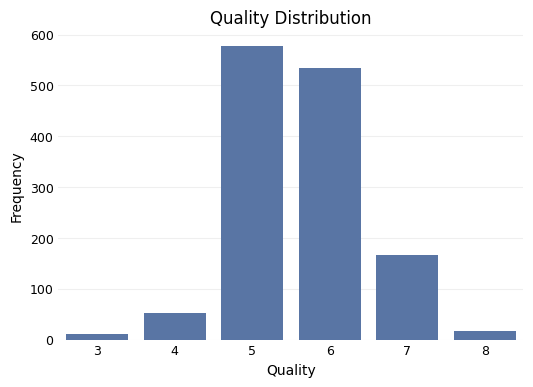

In [8]:
quality_count_plot(wines)

Observations:
- This is an ordinal feature.
- Most wines are rated as 5 or 6, with very few rated as 3, 4 or 8.

Impact:
- For ordinal data like this, Spearman's correlation test should be used. 
- Logistic regression, or a similar classification model, is more appropriate than linear regression. Linear regression is designed for continuous target variable.
- For a logistic regression, class imbalances will have to be handled. Linear regression, on the other hand, is used for predicting continuous outcomes, where the concept of class imbalance does not apply.

## Relationships Between the Target and Predictors

In this section, we will explore how each predictor is related to the target variable, wine quality. Each time we will use this method:
1. Histogram: To check for possible outliers. Box plots identify points that are above or below the IQR. However, this is not the definition I will use. I consider a point an outlier if it deviates very significantly from the central tendency and not just by the IQR. However, how an outlier is defined is not important right now as I intend to use methods availible for model diagnostics.
2. Box Plot: I will use them to visualize the relationship and check for possible non-linearity. If the relationship between each predictor and the target is roughly linear, a linear model is likely appropriate. This information is indicated by the median's location relative to the medians of other groups. For a linear trend, the medians should consistently increase or decrease.
3. Correlation test: Additionally, I will use Spearman's correlation test to see whether there is a relationship and if it is statistically significant. Numeric description also has the benefit of mitigating the issue of misleading visual interpretation of the plots due to some classes having very few counts.

The impact of the observations will be written out at the end of this sub-section.

### Assumptions for Spearman's Correlation Statistical Test

1. Ordinal, Interval, or Ratio Data: As we've seen "quality" is ordinal.
2. Monotonic Relationship: In the box plots, the medians for the 5, 6, and 7 classes must be consistently increasing or decreasing. We will check to ensure this condition is maintained. 3,4 and 8 have small sample sizes and I will soon check what effect this has.
3. Independence: Each measurement represents a unique wine, and physicochemical properties of one wine would influence those of others. If this were the case, it would probably imply a malfunction in the measurement machinery.

### Statistical Hypothesis Testing

As mentioned before, for each predictor and the target, we will perform a Spearman's correlation test.

Null Hypothesis (H0): There is no relationship between the predictor and the target variable, and the population Spearman's correlation coefficient is equal to zero.

Alternative Hypothesis (H1): There is a relationship between the predictor and the target variable, and the calculated correlation coefficient accurately represents this relationship in the population.

We will use a significance level of 0.05 to test these hypotheses. If the p-value calculated from the Spearman's correlation test is less than 0.05, we will reject the null hypothesis in favor of the alternative hypothesis.

*Example:* In the case of quality and fixed acidity (just below), the p-value is below the significance level. We reject the null hypothesis and conclude that there is a statistically significant relationship.

### Quality And Fixed Acidity

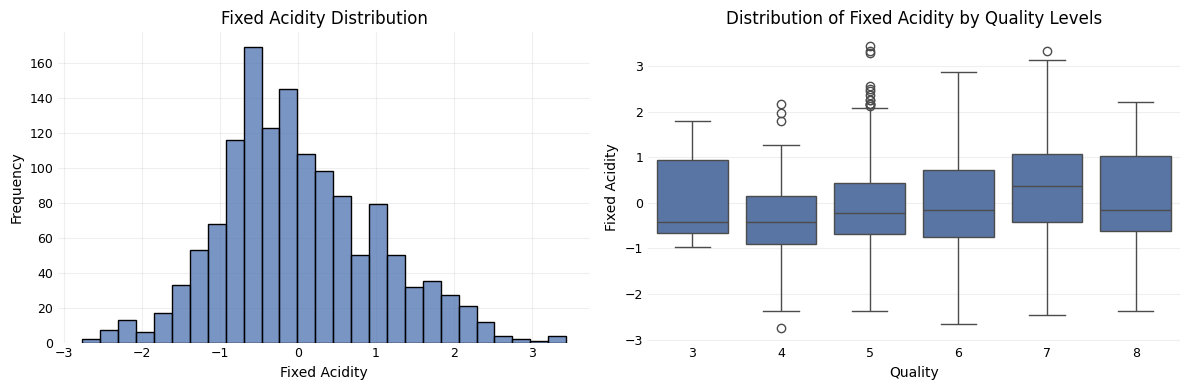

Spearman correlation coefficient: 0.11
p-value: 0.00


In [9]:
relationship(wines, "fixed acidity")

- Features are related. As fixed acidity increases, quality also increases.
- No outliers.
- From the distributions, the relationship seems to be non monotonic.

### Confidence Intervals for the Medians Between Groups of Quality And Fixed Acidity

Let's check if my idea about not interpreting the box plots for the ratings of 3, 4, and 8 is correct. Confidence intervals will be calculated for the medians of the groups we just observed between quality and fixed acidity. Chosen confidence level is 95%.

In [10]:
median_confidence_intervals(wines, "fixed acidity")

Quality 3: [-0.69, 1.23]
Quality 4: [-0.69, -0.04]
Quality 5: [-0.29, -0.16]
Quality 6: [-0.22, -0.10]
Quality 7: [0.14, 0.55]
Quality 8: [-0.62, 1.03]


Observations:
- Confidence intervals for ratings 3, 4, and 8 are very wide and, in some cases, even encompass the much narrower intervals for ratings 5, 6, and 7.
- There is no statistically significant difference between ratings 5 and 6 as the intervals are overlapping. However, I would think that this is not a major issue since there is a statistically significant difference between the groups of ratings 4 and 5 and the group of 6 (confidence intervals are not overlapping). Therefore, there stil exists a statistically significant relationship overall, which is shown by the correlation test.

Impact:
- Medians for ratings 3, 4, and 8 are not meaningful and should not be interpreted. This is imornat, because they could imply non-monotonic relationship.
- Since the number of observations will not be changing, this conclusion should be valid for all relationships between quality and other predictors.

### Quality And Volatile Acidity

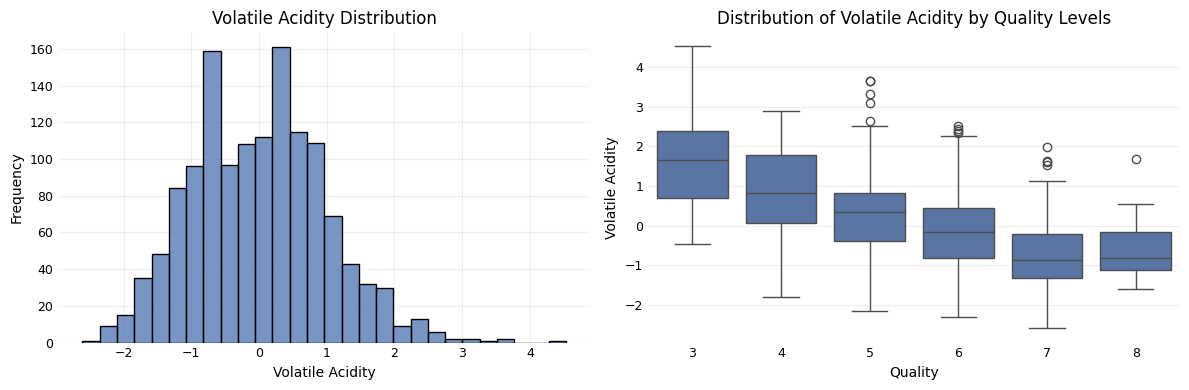

Spearman correlation coefficient: -0.39
p-value: 0.00


In [11]:
relationship(wines, "volatile acidity")

- Features are related. As volatile acidity increases, quality decreases.
- No outliers.

### Quality And Citric Acid

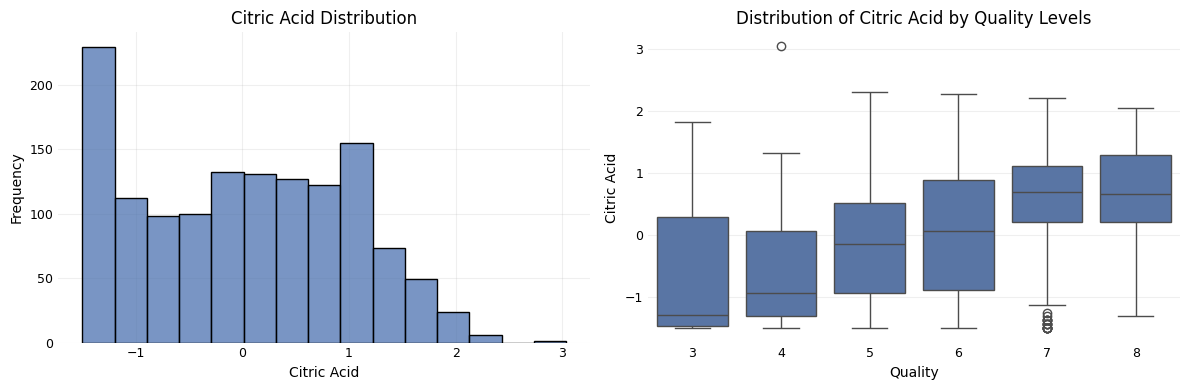

Spearman correlation coefficient: 0.22
p-value: 0.00


In [12]:
relationship(wines, "citric acid")

- Features are related. As citric acid increases, quality also increases.
- No outliers.

### Quality And Residual Sugar

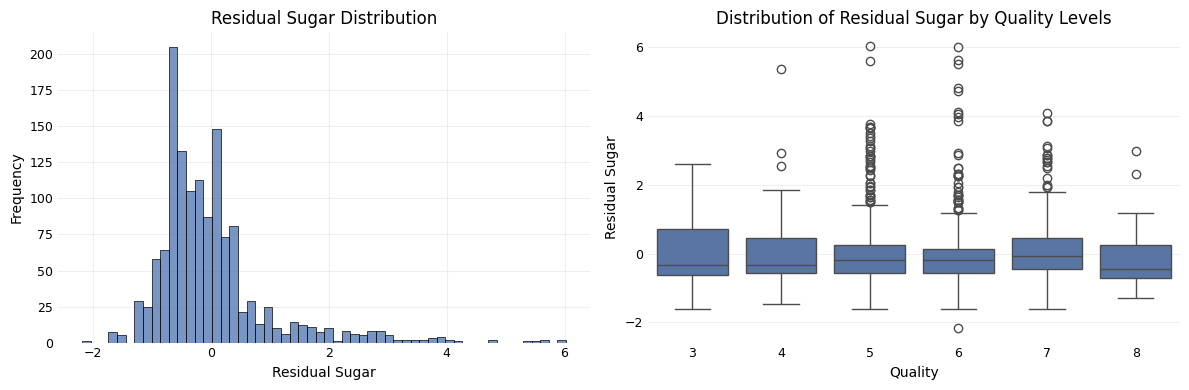

Spearman correlation coefficient: 0.03
p-value: 0.34


In [13]:
relationship(wines, "residual sugar")

- No relation.
- Residual sugar still has possible outliers.

### Quality And Chlorides

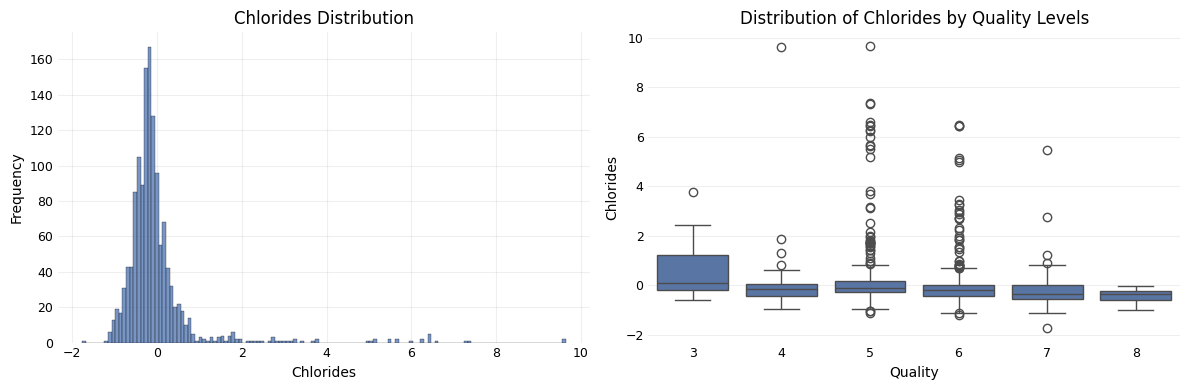

Spearman correlation coefficient: -0.20
p-value: 0.00


In [14]:
relationship(wines, "chlorides")

- Features are related. As chlorides increases, quality decreases.
- Chlorides has possible outliers.

### Quality And Free Sulfur Dioxide

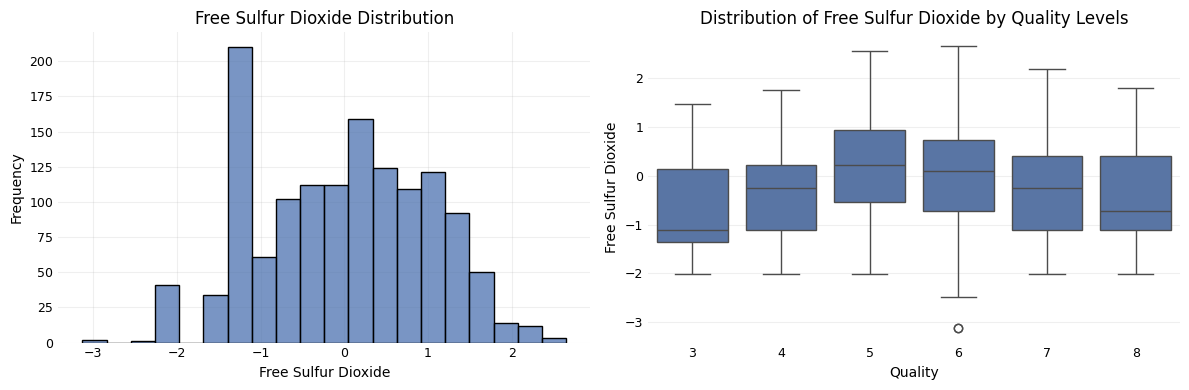

Spearman correlation coefficient: -0.06
p-value: 0.03


In [15]:
relationship(wines, "free sulfur dioxide")

- Features are related. As free sulfur dioxide increases, quality decreases.
- No outliers.
- This relationship particularly looks non-monotonic.

### Confidence Intervals for the Medians Between Groups of Quality And Free Sulfur Dioxide

Let's again calculate the confidence interval for the association above.

In [16]:
median_confidence_intervals(wines, "free sulfur dioxide")

Quality 3: [-1.36, 0.31]
Quality 4: [-1.12, -0.12]
Quality 5: [0.11, 0.31]
Quality 6: [-0.00, 0.21]
Quality 7: [-0.39, -0.12]
Quality 8: [-1.12, 0.40]


Obervations:
- Groups with a small amount of data have very wide intervals and the visual distributions of data with low number of data should not be trusted.

### Quality And Free Total Sulfur Dioxide

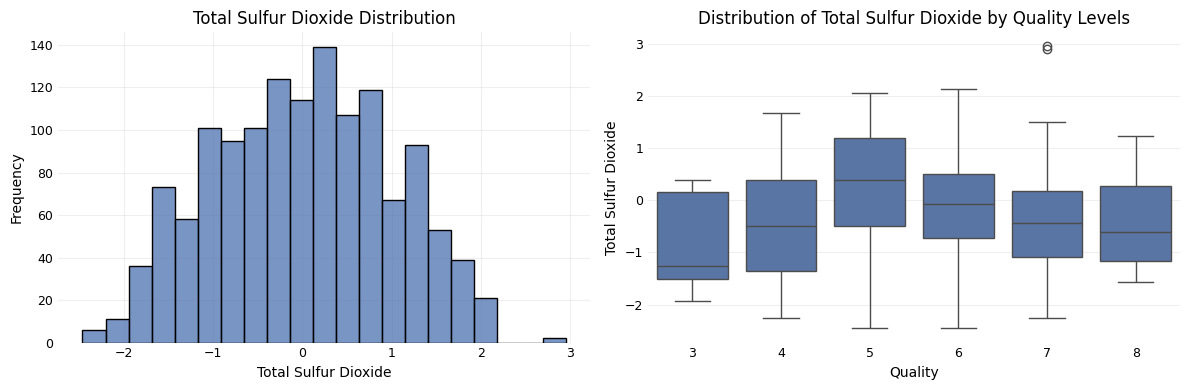

Spearman correlation coefficient: -0.20
p-value: 0.00


In [17]:
relationship(wines, "total sulfur dioxide")

- Features are related. As total sulfur dioxide increases, quality decreases.
- No outliers.

### Quality And Density

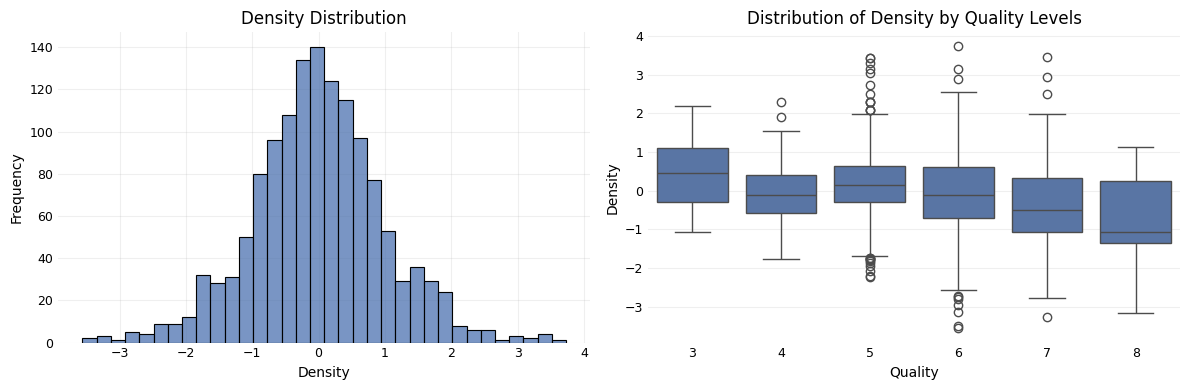

Spearman correlation coefficient: -0.18
p-value: 0.00


In [18]:
relationship(wines, "density")

- Features are related. As density increases, quality decreases.
- No outliers.

### Quality And pH

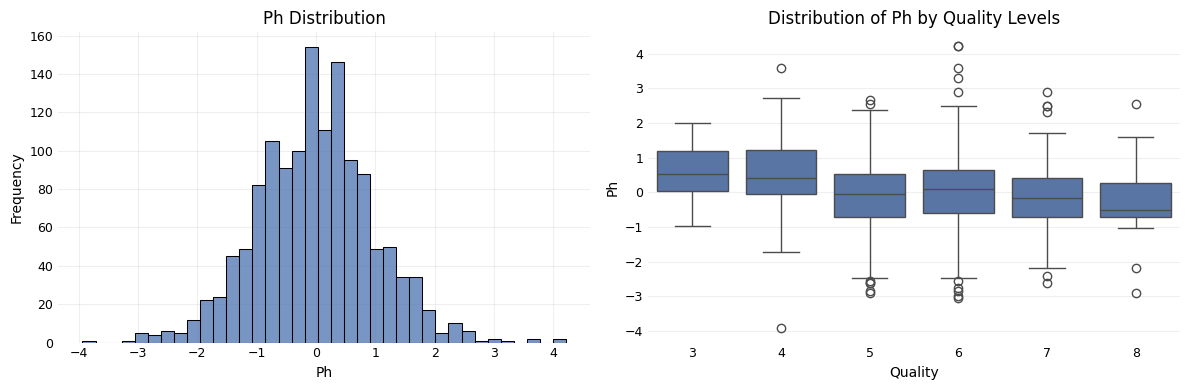

Spearman correlation coefficient: -0.04
p-value: 0.12


In [19]:
relationship(wines, "pH")

- No relation.
- No outliers.

### Quality And Sulphates

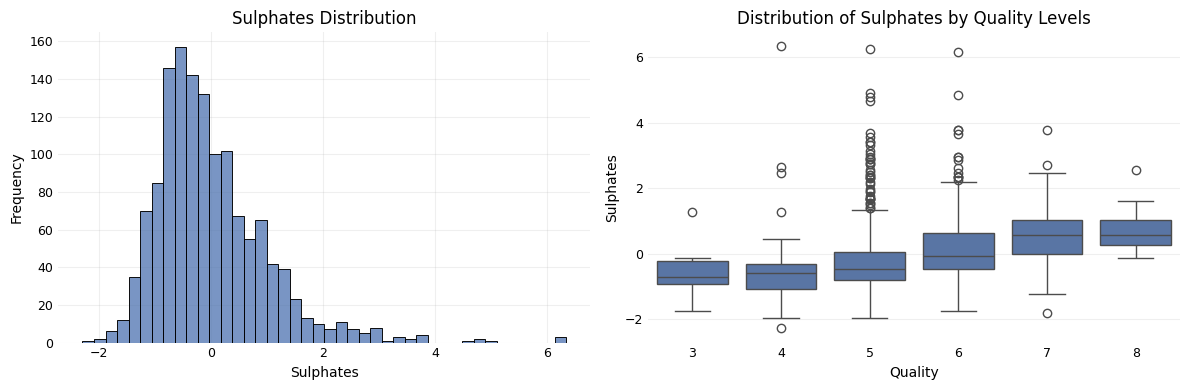

Spearman correlation coefficient: 0.38
p-value: 0.00


In [20]:
relationship(wines, "sulphates")

- Features are related. As sulphates increases, quality increases.
- Possible outlier.

### Quality And Alcohol

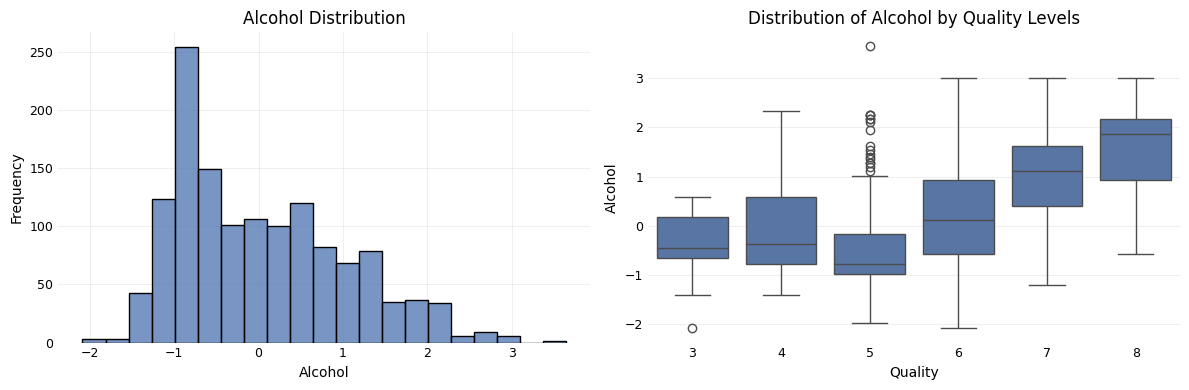

Spearman correlation coefficient: 0.49
p-value: 0.00


In [21]:
relationship(wines, "alcohol")

- Features are related. As alcohol increases, quality increases.
- No outliers.

### Impact

- Remaining outliers will be addressed in the model, as linear models provide useful statistics for identifying them.
- Two features are unrelated to the target, but it is possible that predictors that appear to be unrelated in isolation could become related in the context of a model. In the model, I will include all features.
- Most of relationships are roughly linear, but there are some exceptions. With this particular data, it is not possible to say if this is true or accidental.
- Some of the sample group distributions are probably inaccurate, as indicated by wide confidence intervals, and I would guess that the true relationship is monotonic. We see this with the three groups that have sufficient data, and most visualizations show a monotonic relationship overall, although this could be accidental too. My conclusion is to avoid using methods that generate more data to compensate for class size differences (balancing), as the generated data would likely reflect the potentially inaccurate distribution of our sample.

## Relationships Between Predictors

I will calculate the correlation matrix, but I already know that I will include all features in the model. I will identify and address correlations between predictors using VIF later as this is a more accurate method.

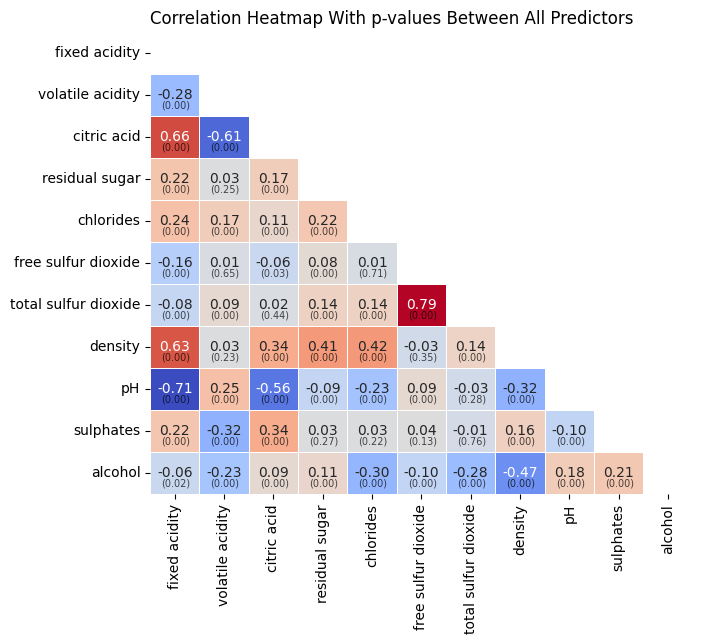

In [22]:
correlation_heatmap(wines, "quality")

Observations:
- Multicollinearity is considered when the correlation coefficients are very high (typically above 0.8 or below -0.8). There are some notable relationships, but this is not severe enough to immediately require removing some of the predictors.
- The variables that are most correlated with others are citric acid, density, fixed acidity, and pH.
- Total sulfur dioxide is highly correlated with free sulfur dioxide.

## Observations Based on EDA

So far, I've done a pairwise analysis, which gives some information whether features have a positive, negative, or no link with the target. However, these findings may be incorrect, as this does not account for associations between the predictors. For the same reason, this method also does not allow for specific numeric comparisons (regression coefficients) between these associations.

Insights:
- Physicochemical factors positively linked with the wine quality are: fixed acidity, citric acid, sulphates, alcohol.
- Negatively linked: volatile acidity, chlorides, free sulfur dioxide, total sulfur dioxide, density.
- No effect: residual sugar, pH.

Also:
- Of the positively correlated features, fixed acidity and citric acid are moderately correlated (0.66) and contain related information.
- Of the netagively correlated features, free sulfur dioxide and total sulfur dioxide are strongly correlated (0.79) and contain similar information.

## Summary

To model wine quality, I should use ordinal logistic regression, address outliers, and associations between the predictors. Tackle class imbalances, but avoid balancing methods. Additionally, I need to handle predictor statistical significance, though this is a general step.

# Machine Learning

The main objectives for this part of the notebook are:
- Develop an accurate ordinal logistic regression classification model.
- Gain insights about factors linked to wine quality.

Standard logistic regression, cannot appropriately model ordered classes because it do not account for the ordinal nature of the data. Instead, it treats each class as distinct and unordered. Ordinal logistic regression is specifically designed to model the inherent order, making it a better choice.

I will not check if the assumptions for this model are met. This would be complicated process for me that would take a lot of time. Instead, I will focus on tasks that are more beneficial for my learning: model refinement and validation. I am aiming to build a model that performs well and generalizes effectively. However, since assumptions might not be met, coefficients could be incorrect, leading to unreliable interpretations and predictions.

## Unbalanced Classes

Addressing class imbalances is important to ensure that the relationships between variables are accurately identified and not skewed by the dominance of one class. In this case, improving classification for small classes can reduce overall accuracy, affecting the model's reliability. It is important to find the right balance. Since before trying it is impossible to know which method would produce better results, I will try a few and compare which performs better. The results will me discussed at the end of this sub-section in a "Summary".

We will compare the results of these methods:
1) Class weights.
2) No measures at all.
3) Balancing with SMOTE.

### Class Weights

In [23]:
X_raw = wines_no_duplicates.drop(columns=["quality"])
y_raw = wines_no_duplicates["quality"]
X_train_unclean, X_test_unclean, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=32, stratify=y_raw
)
X_train = cleaning_pipeline(X_train_unclean)
X_test = cleaning_pipeline(X_test_unclean)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {
    cls: weight for cls, weight in zip(np.unique(y_train), class_weights)
}
sample_weights = np.array([class_weight_dict[cls] for cls in y_train])
model = LogisticAT()
model.fit(X_train, y_train, sample_weight=sample_weights)
y_train_pred = model.predict(X_train)
print("Training Set Classification Report:")
print(classification_report(y_train, y_train_pred))
y_test_pred = model.predict(X_test)
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))

Training Set Classification Report:
              precision    recall  f1-score   support

           3       0.10      0.50      0.17         8
           4       0.08      0.43      0.14        42
           5       0.59      0.41      0.48       461
           6       0.51      0.32      0.39       428
           7       0.33      0.42      0.37       134
           8       0.11      0.57      0.19        14

    accuracy                           0.38      1087
   macro avg       0.29      0.44      0.29      1087
weighted avg       0.49      0.38      0.41      1087

Test Set Classification Report:
              precision    recall  f1-score   support

           3       0.11      0.50      0.18         2
           4       0.12      0.64      0.20        11
           5       0.58      0.40      0.47       116
           6       0.58      0.35      0.43       107
           7       0.28      0.39      0.33        33
           8       0.00      0.00      0.00         3

    accur

Observations:
- Overall accuracy is low, only 38%.
- For the small classes, f1-score is also low. The model tries to classify instances as belonging to the small classes but gets most of them wrong (low precision).
- With different data splits (random_state argument), the assessment parameters vary.
- Test and train accuracies are the same, indicating no overfitting. As long as it is not an issue, I will not be making comments about model variance (possible overfitting).

Impact:
- For a low accuracy model, regression coefficients may not capture the population parameters accurately, and I should look for a better way to address class imbalances.
- To assess model accuracy and variance, I will primarily use a more reliable method: k-fold cross-validation. This is a standard practice.

In [24]:
X_cleaned = cleaning_pipeline(X_raw)
class_weights = compute_class_weight("balanced", classes=np.unique(y_raw), y=y_raw)
class_weight_dict = {
    cls: weight for cls, weight in zip(np.unique(y_raw), class_weights)
}
sample_weights = np.array([class_weight_dict[cls] for cls in y_raw])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)
cv_results = cross_validate(
    model,
    X_cleaned,
    y_raw,
    cv=cv,
    scoring="accuracy",
    return_train_score=True,
    fit_params={"sample_weight": sample_weights}
)
print(f'Accuracy from 5-fold cross-validation: {cv_results["test_score"].mean():.2f}')

Accuracy from 5-fold cross-validation: 0.36


Obseravtions:
- In this case, averaged accuracy is very close to the accuracy for a single test-train split.

Let's check how well the model predicts each class.

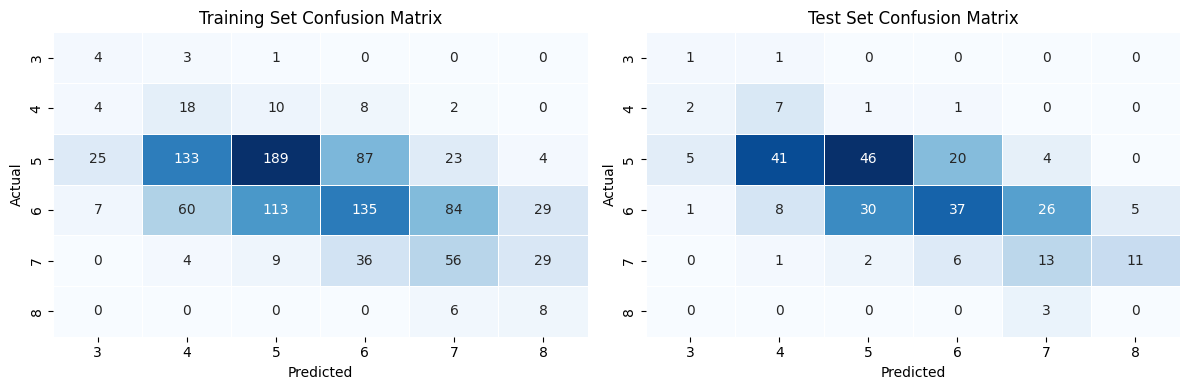

In [25]:
plot_confusion(y_train, y_train_pred, y_test, y_test_pred)

Observations:
- The confusion matrices for both the training and test sets show that the majority of errors are close to the actual values, indicating that the model's misclassifications are not extreme. This suggests that the model is generally performing well and making reasonable predictions. There are no significant or unusual patterns in the misclassifications.

### No Measures (Baseline)

In [26]:
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("Training Set Classification Report:")
print(classification_report(y_train, y_train_pred))
y_test_pred = model.predict(X_test)
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))
cv_results = cross_validate(
    model, X_cleaned, y_raw, cv=cv, scoring="accuracy", return_train_score=True
)
print(f'Accuracy from 5-fold cross-validation: {cv_results["test_score"].mean():.2f}')

Training Set Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        42
           5       0.64      0.73      0.68       461
           6       0.53      0.62      0.57       428
           7       0.56      0.24      0.34       134
           8       0.00      0.00      0.00        14

    accuracy                           0.58      1087
   macro avg       0.29      0.26      0.26      1087
weighted avg       0.55      0.58      0.55      1087

Test Set Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.67      0.77      0.72       116
           6       0.58      0.69      0.63       107
           7       0.73      0.24      0.36        33
           8       0.00      0.00      0.00         3

    accur

Observations:
- Overall model prediction accuracy is about 20% higher than using the weight method. However, the model does not distinguish any traits that would allow for the classification of smaller categories, and consequently, no correct predictions are made for them.

Impact:
- I will explore more solutions that ideally will not have low accuracy and will be able to predict all classes.

Confusion matrix:

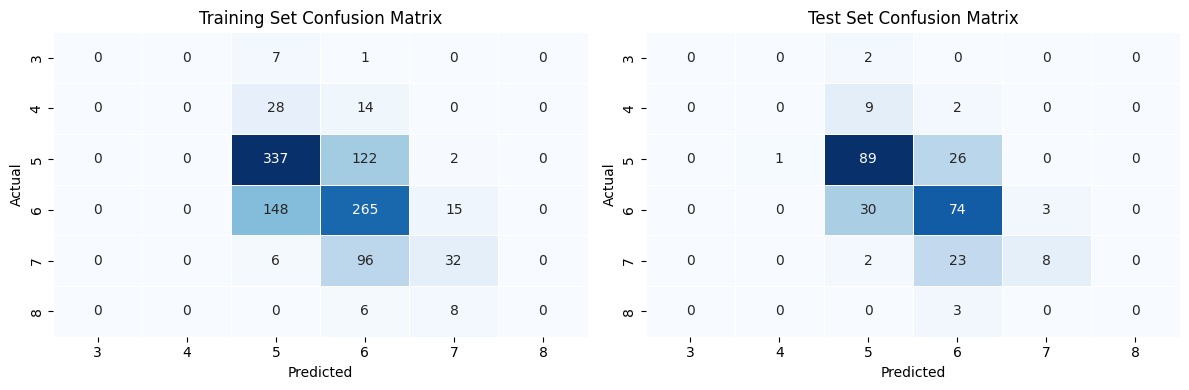

In [27]:
plot_confusion(y_train, y_train_pred, y_test, y_test_pred)

Observations:
- Small class misclassifications are not extreme and remain relatively close to the actual values. For example, when target values are 3 or 4, the model often predicts a 5.
- Model consistently misclassifies "7" as "6".

### Balancing

Finally, even though I previously thought this might not be the best method, let's try balancing the data using SMOTE.

In [28]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
model.fit(X_train_resampled, y_train_resampled)
y_train_pred = model.predict(X_train_resampled)
print("Training Set Classification Report:")
print(classification_report(y_train_resampled, y_train_pred))
y_test_pred = model.predict(X_test)
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))
pipeline = make_pipeline(SMOTE(), model)
cv_results = cross_validate(
    pipeline, X_cleaned, y_raw, cv=cv, scoring="accuracy", return_train_score=True
)
print(f'Accuracy from 5-fold cross-validation: {cv_results["test_score"].mean():.2f}')

Training Set Classification Report:
              precision    recall  f1-score   support

           3       0.80      0.61      0.69       461
           4       0.34      0.41      0.37       461
           5       0.35      0.39      0.37       461
           6       0.34      0.32      0.33       461
           7       0.36      0.39      0.38       461
           8       0.63      0.59      0.61       461

    accuracy                           0.45      2766
   macro avg       0.47      0.45      0.46      2766
weighted avg       0.47      0.45      0.46      2766

Test Set Classification Report:
              precision    recall  f1-score   support

           3       0.09      0.50      0.15         2
           4       0.13      0.64      0.22        11
           5       0.59      0.39      0.47       116
           6       0.55      0.35      0.43       107
           7       0.28      0.39      0.33        33
           8       0.00      0.00      0.00         3

    accur

Obseravtions:
- The model accurately classifies around 38% of the data. These results are the same as weighting.
- A number of smaller classes is also being correctly predicted.

Confusion matrix:

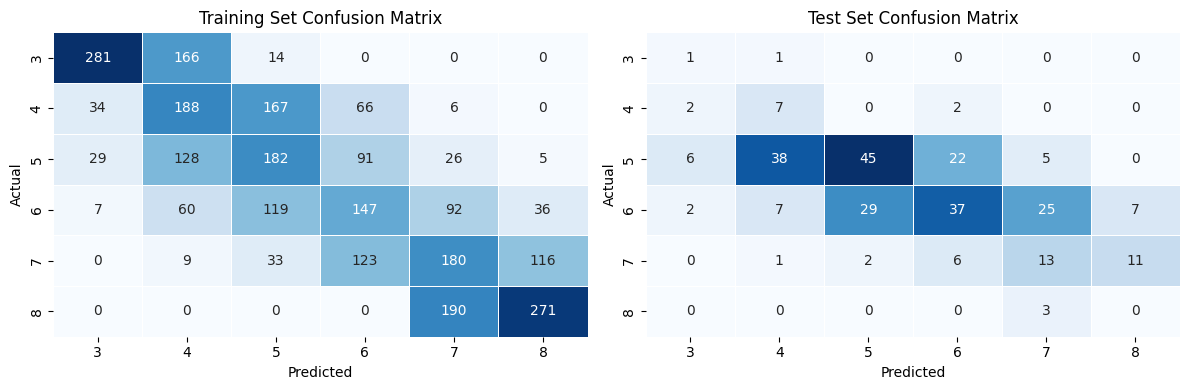

In [29]:
plot_confusion(y_train_resampled, y_train_pred, y_test, y_test_pred)

Observations:
- Errors are certered around the actual values.

## Summary

My efforts to fix class imbalances have been disappointing, as the classification effectiveness remains low. It is probably best to proceed with the baseline model. This particular model has a higher accuracy and even though it is unable to classify smaller classes, the predictions are not too far off. My interest is in the regression coefficients and inference rather than specific classifications. Additionally, no model was able to classify '8' in the test data, but this may be due to having only three instances, which could be coincidental.

*A note from the future: After finishing the project, I think this conclusion is wrong. This will be further discussed in the conclusions.*

## Further Refinement

Let's try other measures to see if model performance can be improved.

We will try these steps:
1) Check if there are beneficial higher order and interaction terms.
2) Look for outliers.
3) Address collinearity.
4) Drop statistically insignificant predictors.

### Residuals

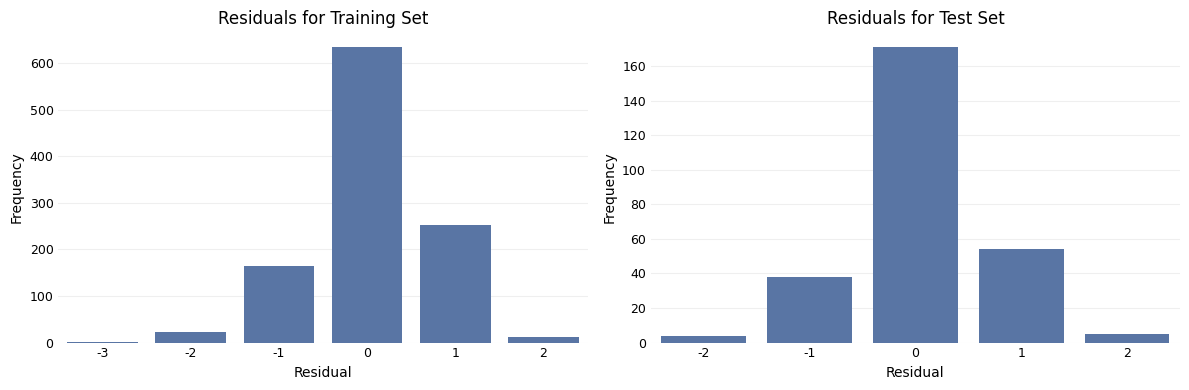

In [30]:
model.fit(X_train, y_train)
y_train_pred_class = model.predict(X_train)
y_test_pred_class = model.predict(X_test)
train_residuals = y_train - y_train_pred_class
test_residuals = y_test - y_test_pred_class
plot_residuals(train_residuals, test_residuals)

Observations:
- The residuals are concentrated around zero, with some deviations on each side and a slight tendency to overestimate. Overall, the model is performing reasonably well, but further refinement could improve accuracy by addressing the sources of these non-zero residuals.

### Higher Order and Interaction Terms

To explore the potential for improving model accuracy, I will generate all interaction terms and higher-order terms up to the 2nd order. The goal of this initial broad analysis is to find if these additional terms can enhance the model's performance. If the accuracy improves, I will then consider a more detailed investigation into specific interactions and higher-order terms. 

In [31]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
model.fit(X_train_poly, y_train)
y_train_pred = model.predict(X_train_poly)
print("Training Set Classification Report:")
print(classification_report(y_train, y_train_pred))
y_test_pred = model.predict(X_test_poly)
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))
X_cleaned_poly = poly.fit_transform(X_cleaned)
cv_results = cross_validate(
    model, X_cleaned_poly, y_raw, cv=cv, scoring="accuracy", return_train_score=True
)
print(f'Accuracy from 5-fold cross-validation: {cv_results["test_score"].mean():.2f}')

Training Set Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.20      0.02      0.04        42
           5       0.64      0.74      0.69       461
           6       0.56      0.58      0.57       428
           7       0.55      0.40      0.46       134
           8       0.00      0.00      0.00        14

    accuracy                           0.60      1087
   macro avg       0.32      0.29      0.29      1087
weighted avg       0.57      0.60      0.58      1087

Test Set Classification Report:
              precision    recall  f1-score   support

           3       1.00      0.50      0.67         2
           4       0.00      0.00      0.00        11
           5       0.71      0.72      0.71       116
           6       0.59      0.73      0.65       107
           7       0.63      0.36      0.46        33
           8       0.00      0.00      0.00         3

    accur

Observations:
- Creating higher-order and interaction terms slightly improved the accuracy; from 0.56 to 0.58.
- Introducing third-order terms causes more overfitting, reducing test accuracy.
- While some individual terms might improve accuracy, others could be reducing it, leading to no overall change. I would have to test each term individually to identify which ones positively impact the model's performance, but for this project I am not going to do this.
- Some of the smaller classes were correctly classified. This is a promising sign. Thsese terms could be identified and added to the model.

### Outliers and High Leverage Points

Leverage measures how far predictor values are from the mean. High leverage points indicate observations with unusual values that have the potential to significantly influence the model. Points above the red dashed line (threshold 2*(p+1)/n) are considered high leverage.

Cook's Distance assesses the overall influence of each observation on the model's predictions and coefficients. High Cook's Distance values identify observations that significantly impact the model. Typically, Cook's Distance values above a standard of 4/n are considered problematic or influential.

To calculate leverage and Cook's Distance, I used a linear regression since "mord" library does not have built-in functions for this and this would have to be done manually. Although ordinal logistic regression is our model, the diagnostics from linear regression still gives valuable insights. This method works because the models are similar in how they analyze relationships.

p is the number of predictors in the model and  n is the number of data points in the dataset.

Number of points above Cook's Distance: 68


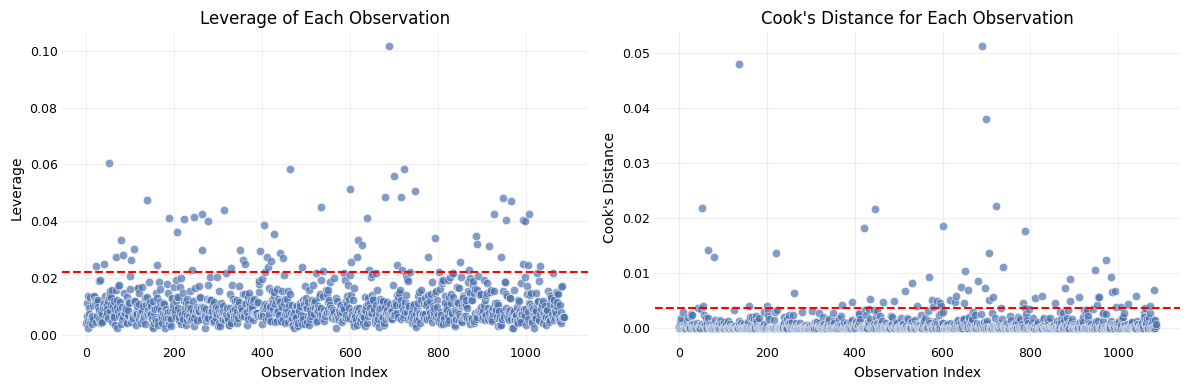

In [32]:
X_train_const = sm.add_constant(X_train)
model_ols = sm.OLS(y_train, X_train_const).fit()
influence = model_ols.get_influence()
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]
n = len(X_train)
p = X_train.shape[1]
influential_points = np.where(cooks_d > 4 / n)[0]
print(f"Number of points above Cook's Distance: {len(influential_points)}")
plot_leverage_cooksd(leverage, cooks_d, p, n)

Observations:
- There are multiple points that have Cook's Distance and leverage values above the thresholds. These observations have a significant influence on the model.

Impact:
- I will remove all influential data points identified by Cook's Distance above the threshold and observe if the model's effectiveness improves.

There is no built-in function to remove high influence points during cross-validation, so I will have to average out the accurasies manually.

In [33]:
X_train_no_outliers = X_train.drop(X_train.index[influential_points])
y_train_no_outliers = y_train.drop(y_train.index[influential_points])
model.fit(X_train_no_outliers, y_train_no_outliers)
y_train_pred = model.predict(X_train_no_outliers)
print("Training Set Classification Report:")
print(classification_report(y_train_no_outliers, y_train_pred))
y_test_pred = model.predict(X_test)
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)
train_scores = []
test_scores = []
for train_idx, test_idx in cv.split(X_cleaned, y_raw):
    X_train_cv, X_test_cv = X_cleaned.iloc[train_idx], X_cleaned.iloc[test_idx]
    y_train_cv, y_test_cv = y_raw.iloc[train_idx], y_raw.iloc[test_idx]
    X_train_cv_const = sm.add_constant(X_train_cv)
    model_ols = sm.OLS(y_train_cv, X_train_cv_const).fit()
    influence = model_ols.get_influence()
    cooks_d = influence.cooks_distance[0]
    n = len(X_train_cv)
    influential_points = np.where(cooks_d > 4 / n)[0]
    X_train_no_outliers = X_train_cv.drop(X_train_cv.index[influential_points])
    y_train_no_outliers = y_train_cv.drop(y_train_cv.index[influential_points])
    model = clone(LogisticAT())
    model.fit(X_train_no_outliers, y_train_no_outliers)
    y_test_pred = model.predict(X_test_cv)
    test_accuracy = accuracy_score(y_test_cv, y_test_pred)
    test_scores.append(test_accuracy)
print(f"Accuracy from 5-fold cross-validation: {np.mean(test_scores):.2f}")

Training Set Classification Report:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00        21
           5       0.69      0.75      0.72       454
           6       0.56      0.62      0.59       416
           7       0.61      0.30      0.40       123
           8       0.00      0.00      0.00         5

    accuracy                           0.62      1019
   macro avg       0.37      0.33      0.34      1019
weighted avg       0.61      0.62      0.61      1019

Test Set Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.72      0.78      0.75       116
           6       0.59      0.72      0.65       107
           7       0.64      0.27      0.38        33
           8       0.00      0.00      0.00         3

    accuracy                           0.65       272
   macro 

Observations:
- Average accuracy has decreased by 0.01.
- From the number of data points in each class (support) in the training set, we can see that the points that were dropped were from the smaller classes. The class "3" has been completely removed, "4" and "8" have beed reduced by half.
- Results are not useful. If I wanted to exclude smaller classes, I could do it myself.

### Collinearity

Variance Inflation Factor (VIF) measures how much the variance of regression coefficients has increased due to multicollinearity. The results after performing an initial pass are shown in the code cell below. My approach was to iteratively drop the feature with the highest VIF, provided it was above 5, and then re-evaluate the VIF values for the remaining variables. Calculations are based on linear regression. This is not a problem, because VIF measures assosiations among predictors, independent of the type of regression used.

In [34]:
high_vif_features = ["fixed acidity"]
X_train = X_train.drop(columns=high_vif_features, errors="ignore")
X_train_const = sm.add_constant(X_train)
model.fit(X_train, y_train)
vif = pd.DataFrame()
vif["Feature"] = X_train_const.columns
vif["VIF"] = [
    variance_inflation_factor(X_train_const.values, i)
    for i in range(X_train_const.shape[1])
]
vif

,Feature,VIF
0,const,1.000000
1,volatile acidity,1.958479
2,citric acid,2.922494
3,residual sugar,1.457012
4,chlorides,1.474212
5,free sulfur dioxide,2.961618
6,total sulfur dioxide,3.222732
7,density,2.533571
8,pH,1.682995
9,sulphates,1.504402


Observations:
- Initially two features had high VIF values: fixed acidity with 8.2 and density with 6.9. With the third highest being 3.7 (pH).

Impact:
- I removed fixed acidity. After removing this feature, the VIF for density dropped significantly. 

### Statistical Significance

I will apply ordinal logistic regression "statsmodels" library to assess statistical significance. "Mord" library does not offer this functionality. I identified statistically insignificant features based on p-values and performed backward selection, iteratively dropping features with the highest p-values. The significance level used is 0.05.

In [35]:
high_p_value_features = ["density", "residual sugar", "free sulfur dioxide"]
X_train = X_train.drop(columns=high_p_value_features, errors="ignore")
model_ordinal = OrderedModel(y_train, X_train, distr='logit')
result = model_ordinal.fit(method='lbfgs', maxiter=1000)
result.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
volatile acidity,-0.6417,0.083,-7.691,0.000,-0.805,-0.478
citric acid,-0.2179,0.091,-2.392,0.017,-0.397,-0.039
chlorides,-0.2073,0.075,-2.778,0.005,-0.354,-0.061
total sulfur dioxide,-0.1886,0.065,-2.916,0.004,-0.315,-0.062
pH,-0.2372,0.079,-2.998,0.003,-0.392,-0.082
sulphates,0.4109,0.074,5.576,0.000,0.266,0.555
alcohol,0.9432,0.076,12.366,0.000,0.794,1.093
3/4,-5.6514,0.361,-15.647,0.000,-6.359,-4.944
4/5,0.6435,0.173,3.727,0.000,0.305,0.982
5/6,1.2451,0.046,26.823,0.000,1.154,1.336


Observations:
- Three features had p-values above 0.05. The removal order was: density, residual sugar and free sulfur dioxide.
- I also checked fixed acidity. If it was still in the model, it would not be statistically significant.

Impact:
- Three statisticaly insignificant features have been removed. By the order of their removal, these were: density, residual sugar, free sulfur dioxide.

## Summary

In this subsection, I took steps to improve the model's performance, but most actions did not produce positive results. The only lasting effect is the removal of fixed acidity, which was highly correlated with other variables and statisctilally insignificant predictors: density, residual sugar and free sulfur dioxide.

## Insights

In this section, I will address the project objective by identifying how physicochemical factors influence wine quality, and rank these factors based on their regression coefficients.

### Regression Coefficients

In [36]:
model = LogisticAT()
model.fit(X_train, y_train)
model.coef_

array([-0.67263529, -0.21831724, -0.23169632, -0.15303956, -0.26195416,
        0.40631549,  0.93770621])

Observations:
- Comparing linear regression (table above) and ordinal logistic regression, the regression coefficients are in the same direction and have the same relative sizes, but their magnitudes differ.
- Unfortunately "mord" library does not offer a simple way to see confidence intervals.

Impact:
- I will calculate the 95% confidence intervals using bootstrapping.

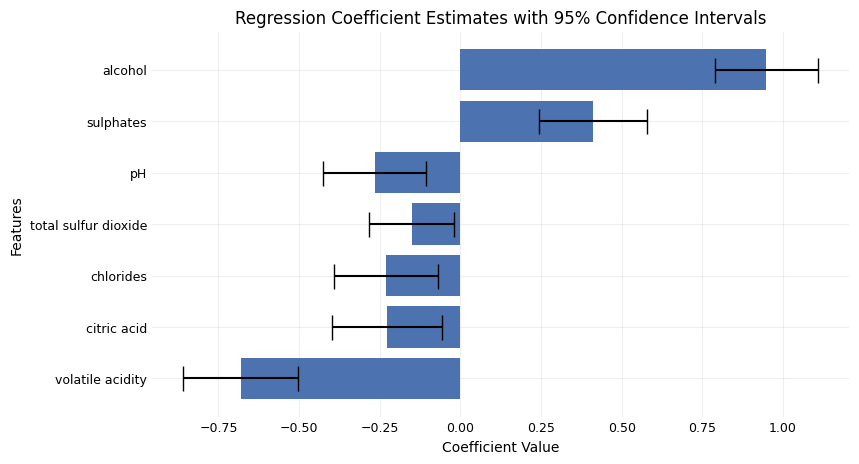

In [37]:
n_bootstraps = 1000
bootstrap_coeffs = np.zeros((n_bootstraps, X_train.shape[1]))
for i in range(n_bootstraps):
    X_resampled, y_resampled = resample(X_train, y_train)
    model = LogisticAT()
    model.fit(X_resampled, y_resampled)
    bootstrap_coeffs[i] = model.coef_
lower_bound = np.percentile(bootstrap_coeffs, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_coeffs, 97.5, axis=0)
mean_coeffs = np.mean(bootstrap_coeffs, axis=0)
error_bars = (upper_bound - lower_bound) / 2
coefficients_with_intervals(X_train.columns, mean_coeffs, error_bars)

Observations:
- Alcohol has the highest positive influence on wine quality, followed by sulphates, which also has a positive influence. The other four features — pH, total sulfur dioxide, chlorides, and citric acid — have negative influences, but since their confidence intervals are overlaping, it is not possible to rank their influence in the population (differences are not statistically significant). Volatile acidity has the largest negative influence.

### Comparing Results from EDA and Regression

- Positive effect: Based on EDA, fixed acidity, citric acid, sulphates, and alcohol had a positive effect on wine quality, while based on regression, only alcohol and sulphates did. Two out of four were correct.
- Negative effect: EDA identified volatile acidity, chlorides, free sulfur dioxide, total sulfur dioxide, and density as having negative effects. Out of these, free sulfur dioxide and density had no effect, while pH was incorrectly identified as having no influence (by EDA).
- No effect: EDA correctly identified only residual sugar. It was wrong about pH and missed density and free sulfur dioxide.
- Citric acid was the most misclassified, as EDA indicated a positive relationship with quality, but it is negative.
- During the EDA, I hypothesized that fixed acidity was related to quality. After performing regression analysis, I concluded that it is not.

## Summary of the Results

Feature assosiations with wine quality:

1. Largest positive influence: alcohol.
2. Positive influence: sulphites.
3. Negative influence and not possible to say which is larger: pH, total sulfur dioxide, chlorides, and citric acid.
4. Largest negative influence: volatile acidity.
5. No statistically significant influence: density, residual sugar, free sulfur dioxide, and fixed acidity.
6. Fixed acidity doesn't add unique value. Other features collectively contain similar information.

Example of coefficient interpretation. Given that the variable alcohol has been log-transformed and then normalized using a standard scaler, and the regression coefficient for alcohol is 0.94 in an ordinal logistic regression model: 

For each one standard deviation increase in the log-transformed alcohol content, the log-odds of the wine being in a higher quality category increase by 0.94. This translates to an odds ratio of $e^{0.94} \approx 2.56$ meaning the odds of the wine being in a higher quality category increase by approximately 156% - calculated as $(2.56 - 1) \times 100$.

# Conclusions

Class imbalances:
- The primary issue remains class imbalances. I could look for more ways to address this or check the regression coefficients from other methods I have explored. If the coefficients were the same, this would give more validity to my findings.
- For this problem, applying a dummy classifier may be beneficial as it provides a baseline performance measure. This could help to understand if various solutions are adding value.
- I think I chose the wrong method for addressing imbalances, as my model is designed for medium-quality wines and is not applicable below or above that range. Additionally, the baseline model was consistently classifying one of the classes lower than it should have. The techniques I tried helped with this. If I were to redo this project, I would use weighted classes.

Other:
- The current model's performance suggests that the model is biased and there are factors that are not included, such as climate, grape variety, and winemaking techniques that might influence wine quality. Incorporating these factors could improve the model's predictive power.
- I could spend more time on higher-order and interaction terms. Exploring interaction effects more thoroughly could help move beyond the absolute interpretation of single regression coefficients. This would provide a more nuanced view and avoid simplistic conclusions from just looking at individual variables. I avoided doing this, since this may complicate the explainability of the relationships.
- Check model assumptions.
- Check if the assumptions for the Central Limit Theorem (CLT) are valid. I did not check this explicitly, but I used confidence intervals, which rely on the normality assumption implied by the CLT.
- Since hypothesis testing is performed multiple times, I should consider adjusting the significance level to reduce the chance of Type I errors.
- I've learned that "statsmodels" indeed has a model for ordinal logistic regression, called "OrderedModel". This was an oversight on my part. Multicollinearity and outliers can likely be addressed using this model rather than linear regression.

# Linear Regression (Additional Part)

Initially, I performed a linear regression analysis as listed by the requirements. However, I soon found that this approach was unsuitable for the data. Linear regression is generally used for continuous data, and this mismatch was visible from the residual plot, which showed clear correlated patterns. Despite attempts to fix this, the linear regression model produced poor results, with a low R² metric. Therefore, I switched to a more appropriate model: ordinal logistic regression.

This part of the project is not critical, and I would omit it in a final presentation. I did not write descriptions or comments and there could be errors. Additionally, I did not perform cross-validation for the linear regression model, as I did not know about its importance at the time. The main focus of this project is the ordinal logistic regression analysis presented above.

I did not write a summary at the end, but as shown in the table in the end, this model produces similar results to the ordinal logistic regression, with only the magnitudes of the regression coefficients being different.

## Model Baseline

In [38]:
X_raw = wines_no_duplicates.drop(columns=["quality"])
y_raw = wines_no_duplicates["quality"]
X_train_unclean, X_test_unclean, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=30, stratify=y_raw
)
X_train = cleaning_pipeline(X_train_unclean)
X_test = cleaning_pipeline(X_test_unclean)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())
y_test_pred = model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
print(f"R² score for the test data: {r2_test:.4f}")

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     56.97
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           2.66e-99
Time:                        12:30:55   Log-Likelihood:                -1082.8
No. Observations:                1087   AIC:                             2190.
Df Residuals:                    1075   BIC:                             2249.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.6256 

### Residuals

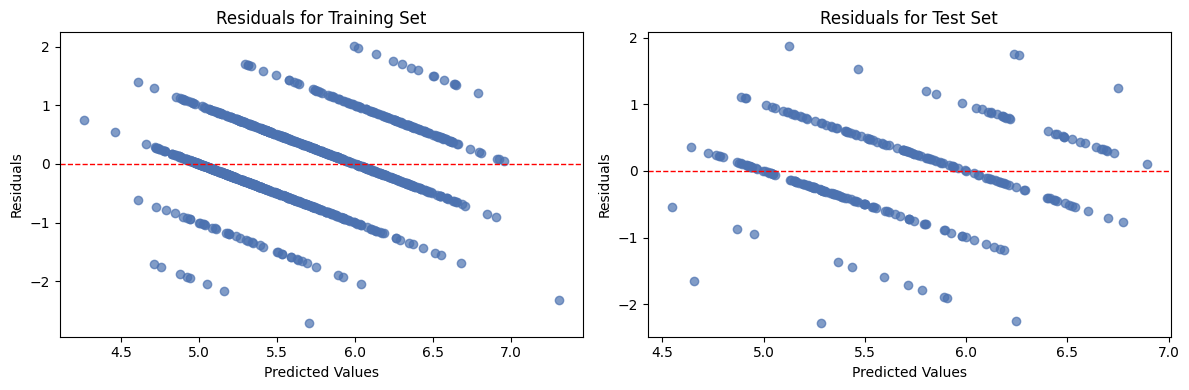

In [39]:
y_train_pred = model.predict(X_train)
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(y_train_pred, train_residuals, alpha=0.7)
ax[0].axhline(0, color="r", linestyle="--", linewidth=1)
ax[0].set_title("Residuals for Training Set")
ax[0].set_xlabel("Predicted Values")
ax[0].set_ylabel("Residuals")
ax[1].scatter(y_test_pred, test_residuals, alpha=0.7)
ax[1].axhline(0, color="r", linestyle="--", linewidth=1)
ax[1].set_title("Residuals for Test Set")
ax[1].set_xlabel("Predicted Values")
ax[1].set_ylabel("Residuals")
plt.tight_layout()

## Non-constant Variance of Error Terms

### Log Transformation

In [40]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)
model_train_log = sm.OLS(y_train_log, X_train).fit()
y_train_pred_log = model_train_log.predict(X_train)
y_test_pred_log = model_train_log.predict(X_test)
y_train_pred = np.exp(y_train_pred_log)
y_test_pred = np.exp(y_test_pred_log)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
n_train, p_train = X_train.shape
adj_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)
print(f"Training R-squared: {round(r2_train, 3)}")
print(f"Training Adjusted R-squared: {round(adj_r2_train, 3)}")
print(f"Test R-squared: {round(r2_test, 3)}")

Training R-squared: 0.365
Training Adjusted R-squared: 0.358
Test R-squared: 0.364


### Square Root Transformation

In [41]:
y_train_sqrt = np.sqrt(y_train)
y_test_sqrt = np.sqrt(y_test)
model_train_sqrt = sm.OLS(y_train_sqrt, X_train).fit()
y_train_pred_sqrt = model_train_sqrt.predict(X_train)
y_test_pred_sqrt = model_train_sqrt.predict(X_test)
y_train_pred = y_train_pred_sqrt**2
y_test_pred = y_test_pred_sqrt**2
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
n_train, p_train = X_train.shape
adj_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)
print(f"Training R-squared: {round(r2_train, 3)}")
print(f"Training Adjusted R-squared: {round(adj_r2_train, 3)}")
print(f"Test R-squared: {round(r2_test, 3)}")

Training R-squared: 0.368
Training Adjusted R-squared: 0.361
Test R-squared: 0.363


### Weighted Least Squares

In [42]:
model_initial = sm.OLS(y_train, X_train).fit()
residuals = model_initial.resid
weights = 1 / (residuals**2)
model_wls = sm.WLS(y_train, X_train, weights=weights).fit()
y_train_pred = model_wls.predict(X_train)
y_test_pred = model_wls.predict(X_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
n_train, p_train = X_train.shape
adj_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)
print(f"Training R-squared: {round(r2_train, 3)}")
print(f"Training Adjusted R-squared: {round(adj_r2_train, 3)}")
print(f"Test R-squared: {round(r2_test, 3)}")

Training R-squared: 0.368
Training Adjusted R-squared: 0.361
Test R-squared: 0.36


## Polynomial and Interaction Terms

In [43]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
model_poly = sm.OLS(y_train, X_train_poly).fit()
y_train_pred = model_poly.predict(X_train_poly)
y_test_pred = model_poly.predict(X_test_poly)
r2_train = model_poly.rsquared
r2_test = r2_score(y_test, y_test_pred)
n_train, p_train = X_train_poly.shape
adj_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)
print(f"Training R-squared: {round(r2_train, 3)}")
print(f"Training Adjusted R-squared: {round(adj_r2_train, 3)}")
print(f"Test R-squared: {round(r2_test, 3)}")

Training R-squared: 0.454
Training Adjusted R-squared: 0.404
Test R-squared: 0.371


### Residuals

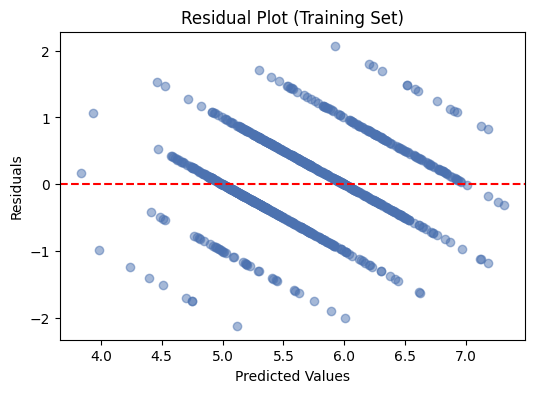

In [44]:
residuals_train = y_train - y_train_pred
plt.figure(figsize=(6, 4))
plt.scatter(y_train_pred, residuals_train, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.title("Residual Plot (Training Set)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals");

## Outliers

Studentized residuals.

Potential outliers and influential points based on studentized residuals:
[ 583  670  671  735  790  817  936 1083]


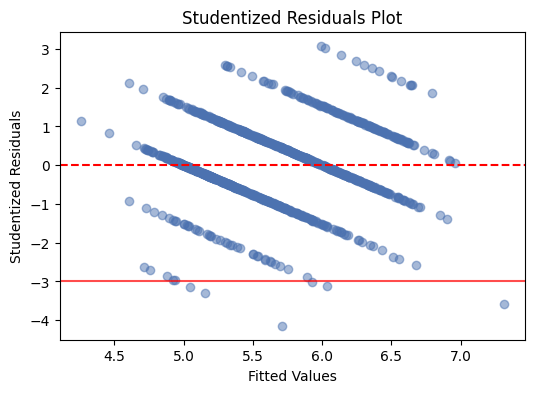

In [45]:
influence = model.get_influence()
studentized_residuals = influence.resid_studentized_internal
high_residuals = np.abs(studentized_residuals) > 3
outliers = np.where(high_residuals)[0]
print("Potential outliers and influential points based on studentized residuals:")
print(outliers)
plt.figure(figsize=(6, 4))
plt.scatter(model.fittedvalues, studentized_residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.axhline(y=-3, color="r", linestyle="-", alpha=0.7)
plt.title("Studentized Residuals Plot")
plt.xlabel("Fitted Values")
plt.ylabel("Studentized Residuals");

### Model Without Outliers

In [46]:
X_train_clean = X_train.drop(index=X_train.index[outliers])
y_train_clean = y_train.drop(index=X_train.index[outliers])
model_clean = sm.OLS(y_train_clean, X_train_clean).fit()
y_train_pred = model_clean.predict(X_train_clean)
y_test_pred = model_clean.predict(X_test)
r2_train = model_clean.rsquared
r2_test = r2_score(y_test, y_test_pred)
n_train, p_train = X_train_clean.shape
adj_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)
print(f"Training R-squared: {round(r2_train, 3)}")
print(f"Training Adjusted R-squared: {round(adj_r2_train, 3)}")
print(f"Test R-squared: {round(r2_test, 3)}")

Training R-squared: 0.389
Training Adjusted R-squared: 0.382
Test R-squared: 0.357


## High Leverage Points

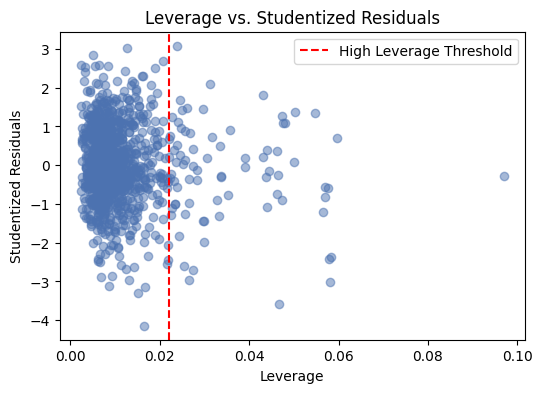

In [47]:
leverage = influence.hat_matrix_diag
plt.figure(figsize=(6, 4))
plt.scatter(leverage, studentized_residuals, alpha=0.5)
plt.axvline(
    x=2 * np.mean(leverage), color="r", linestyle="--", label="High Leverage Threshold"
)
plt.xlabel("Leverage")
plt.ylabel("Studentized Residuals")
plt.title("Leverage vs. Studentized Residuals")
plt.legend();

In [48]:
high_leverage_threshold = 2 * np.mean(leverage)
high_leverage_points = np.where(leverage > high_leverage_threshold)[0]
high_residual_points = np.where(np.abs(studentized_residuals) > 2)[0]
influential_points = np.intersect1d(high_leverage_points, high_residual_points)
print("Influential points based on high leverage and high residuals:")
print(influential_points)

Influential points based on high leverage and high residuals:
[ 108  306  350  388  660  670  671  735 1003]


removing the top 1% of leverage points.

In [49]:
percentile_threshold = 99
leverage_threshold = np.percentile(leverage, percentile_threshold)
high_leverage_points = np.where(leverage > leverage_threshold)[0]
print(
    f"Removing points with leverage above the {percentile_threshold}th percentile (threshold = {leverage_threshold}):"
)
X_clean = X_train.drop(index=X_train.index[high_leverage_points])
y_clean = y_train.drop(index=X_train.index[high_leverage_points])
model = sm.OLS(y_clean, X_clean).fit()
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
r2_train = r2_score(y_train, y_train_pred)
n_train, p_train = X_train.shape
adj_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)
r2_test = r2_score(y_test, y_test_pred)
print(f"Training R-squared: {round(r2_train, 3)}")
print(f"Training Adjusted R-squared: {round(adj_r2_train, 3)}")
print(f"Test R-squared: {round(r2_test, 3)}")

Removing points with leverage above the 99th percentile (threshold = 0.050003719421327954):
Training R-squared: 0.367
Training Adjusted R-squared: 0.36
Test R-squared: 0.359


### Multicollinearity

In [50]:
vif = pd.DataFrame()
vif["Feature"] = X_train.columns
vif["VIF"] = [
    round(variance_inflation_factor(X_train.values, i), 2)
    for i in range(X_train.shape[1])
]
vif

,Feature,VIF
0,const,1.00
1,fixed acidity,8.32
2,volatile acidity,1.94
3,citric acid,3.31
4,residual sugar,1.81
5,chlorides,1.45
6,free sulfur dioxide,2.91
7,total sulfur dioxide,3.27
8,density,6.95
9,pH,3.56


No high leverage points:

In [51]:
vif = pd.DataFrame()
vif["Feature"] = X_clean.columns
vif["VIF"] = [
    round(variance_inflation_factor(X_clean.values, i), 2)
    for i in range(X_clean.shape[1])
]
vif

,Feature,VIF
0,const,1.00
1,fixed acidity,8.54
2,volatile acidity,1.97
3,citric acid,3.34
4,residual sugar,1.76
5,chlorides,1.40
6,free sulfur dioxide,2.96
7,total sulfur dioxide,3.29
8,density,6.93
9,pH,3.63


### Deciding on Important Variables

Backwards selection

In [52]:
X_dropped = X_clean.drop(
    columns=["residual sugar", "density", "free sulfur dioxide", "fixed acidity"]
)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dropped)
X_scaled = pd.DataFrame(X_scaled, columns=X_dropped.columns, index=X_dropped.index)
X_scaled["const"] = 1.0
model = sm.OLS(y_clean, X_scaled).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     92.99
Date:                Wed, 12 Jun 2024   Prob (F-statistic):          7.53e-106
Time:                        12:30:56   Log-Likelihood:                -1064.2
No. Observations:                1076   AIC:                             2144.
Df Residuals:                    1068   BIC:                             2184.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.6292      0.020    282.760      0.000       5.590       5.668
volatile acidity        -0.2260      0.026     -8.708      0.000      -0.277      -0.175
citric acid             -0.0651      0.030     -2.158      0.031      -0.124      -0.006
chlorides               -0.0745      0.023     -3.256      0.001      -0.119      -0.030
total sulfur dioxide    -0.0422      0.021     -2.046      0.041      -0.083      -0.002
pH                      -0.0866      0.025     -3.410      0.001      -0.137      -0.037
sulphates                0.1808      0.023      8.020      0.000       0.137       0.225
alcohol                  0.3248      0.023     14.365      0.000       0.280       0.369
==============================================================================
Omnibus:                       13.572   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               18.006
Skew:                          -0.147   Prob(JB):                     0.000123
Kurtosis:                       3.562   Cond. No.                         2.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""